In [121]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import load_preprocessed_mnist

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [ ]:
# Read and process data:
data, data_label_array, feature_labels, scaler = load_preprocessed_mnist()

# Parameters:
n = data.shape[0]
d = data.shape[1]
k = 10

In [137]:
data_labels

array([2, 6, 4, ..., 5, 4, 8])

In [140]:
np.sum(data_labels == flatten_labels(kmeans_labels))

431

In [134]:
data.shape

(4000, 40)

### KMeans

In [43]:
np.random.seed(342)
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, average = True, normalize = True)

26.188899077666676

In [130]:
kmeans_labels

[{9},
 {5},
 {1},
 {3},
 {8},
 {6},
 {7},
 {4},
 {7},
 {7},
 {7},
 {2},
 {8},
 {3},
 {6},
 {1},
 {1},
 {8},
 {4},
 {4},
 {5},
 {3},
 {5},
 {9},
 {5},
 {2},
 {3},
 {1},
 {3},
 {3},
 {8},
 {2},
 {4},
 {5},
 {6},
 {6},
 {6},
 {1},
 {2},
 {8},
 {4},
 {2},
 {1},
 {6},
 {8},
 {4},
 {2},
 {6},
 {0},
 {3},
 {5},
 {2},
 {6},
 {2},
 {6},
 {2},
 {1},
 {6},
 {6},
 {1},
 {8},
 {2},
 {3},
 {6},
 {9},
 {0},
 {1},
 {8},
 {8},
 {5},
 {3},
 {0},
 {0},
 {0},
 {4},
 {6},
 {3},
 {1},
 {7},
 {1},
 {1},
 {7},
 {1},
 {1},
 {4},
 {7},
 {7},
 {4},
 {0},
 {7},
 {1},
 {9},
 {1},
 {2},
 {2},
 {7},
 {1},
 {8},
 {8},
 {3},
 {8},
 {6},
 {6},
 {2},
 {0},
 {2},
 {0},
 {8},
 {3},
 {0},
 {3},
 {2},
 {5},
 {8},
 {3},
 {8},
 {0},
 {8},
 {0},
 {3},
 {5},
 {5},
 {9},
 {3},
 {0},
 {8},
 {9},
 {3},
 {1},
 {6},
 {5},
 {1},
 {5},
 {0},
 {1},
 {0},
 {5},
 {6},
 {5},
 {2},
 {6},
 {7},
 {1},
 {3},
 {8},
 {2},
 {0},
 {0},
 {8},
 {3},
 {2},
 {5},
 {6},
 {0},
 {2},
 {7},
 {2},
 {1},
 {4},
 {8},
 {3},
 {3},
 {5},
 {6},
 {6},
 {2},
 {2}

### IMM

In [50]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_centers = update_centers(data, kmeans.cluster_centers_, exkmc_assignment)
imm_weighted_depth = int(exkmc_tree.get_weighted_average_depth(data))
kmeans_cost(data, kmeans.cluster_centers_, exkmc_assignment, average = True, normalize = True)

32.6024967223861

In [51]:
imm_weighted_depth

6

In [52]:
exkmc_tree.depth

9

### Decision Forest

In [123]:
np.random.seed(342)

In [124]:
# Module Parameters:
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 1000
n_sets = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : [1, 2],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.1
}

# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : 9
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, 9 + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.25
}

# Oblique Forest:
oblique_forest_tree_params = {
    'max_depth' : 2
}

oblique_forest_params = {
    'tree_model' : ObliqueTree,
    'tree_params' : oblique_forest_tree_params,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}


# SVM Forest:
forest_tree_params_svm = {}

forest_params_svm = {
    'tree_model' : SVMTree,
    'tree_params' : forest_tree_params_svm,
    'num_trees' : n_trees,
    'max_features' : 2,
    'max_labels' : 1,
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}


# ExKMC Forest:
forest_tree_params_exkmc = {
    'k' : k,
    'kmeans' : kmeans,
    'max_leaf_nodes' : 2*k,
    'imm' : True
}

forest_params_exkmc = {
    'tree_model' : ExkmcTree,
    'tree_params' : forest_tree_params_exkmc,
    'num_trees' : 1,
    'max_features' : data.shape[1],
    'max_labels' : k,
    'feature_pairings' : [list(range(d))],
    'train_size' : 1
}


# Voronoi Decision Set:
voronoi_params = {
    'centers' : kmeans.cluster_centers_,
    'num_sets' : n_sets,
    'num_conditions' : 2,
    'feature_pairings' : [list(range(d))]
}

In [125]:
forest = DecisionForest(**forest_params_depth_2)
forest.fit(data, kmeans_labels)

In [104]:
forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

In [17]:
# Takes some time to run!
oblique_forest = DecisionForest(**oblique_forest_params)
oblique_forest.fit(data, kmeans_labels)

KeyboardInterrupt: 

In [21]:
svm_forest = DecisionForest(**forest_params_svm)
svm_forest.fit(data, kmeans_labels)

In [22]:
exkmc_forest = DecisionForest(**forest_params_exkmc)
exkmc_forest.fit(data, kmeans_labels)

In [33]:
voronoi_set = VoronoiSet(**voronoi_params)
voronoi_set.fit(data, kmeans_labels)

### Pruning

In [126]:
model = forest
search_range = np.linspace(0,10,101)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

Text(0, 0.5, 'Cost')

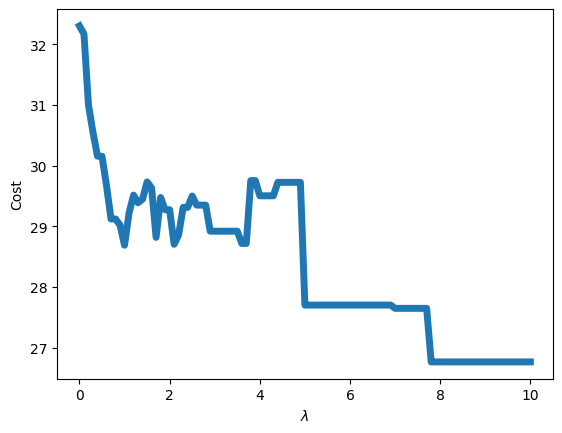

In [127]:
plt.plot(search_range, objective_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

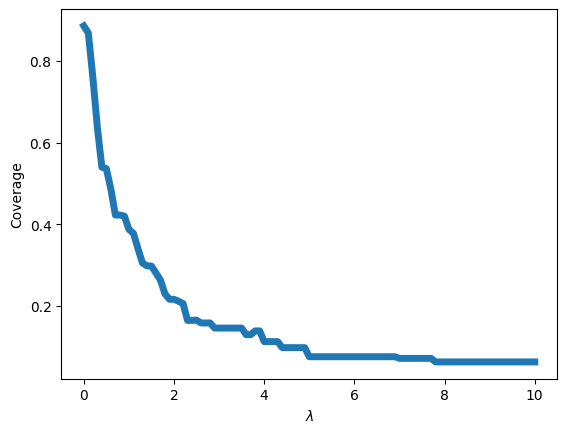

In [128]:
plt.plot(search_range, coverage_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

In [26]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.5,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,10,101),
    'cpu_count' : 1
}

In [27]:
forest.prune(**prune_params)
forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)

In [28]:
forest_depth_5.prune(**prune_params)
forest_depth_5_prune_predictions = forest_depth_5.pruned_predict(data, rule_labels = False)

In [ ]:
oblique_forest.prune(**prune_params)
oblique_forest_prune_predictions = oblique_forest.pruned_predict(data, rule_labels = False)